In [20]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image


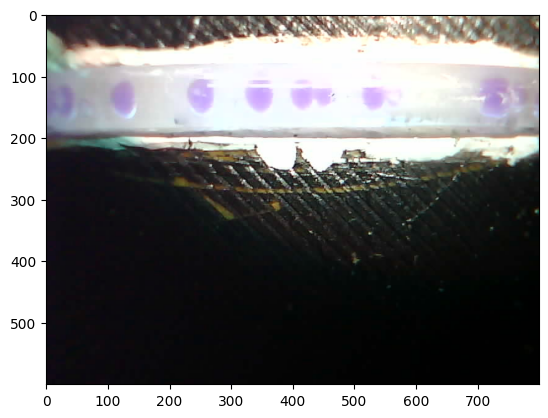

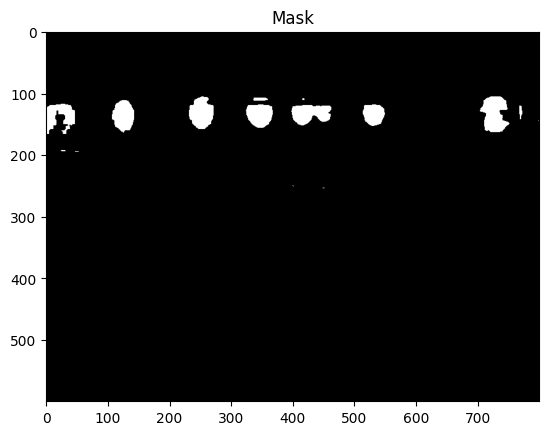

In [40]:
from utils.filefinder import getFilesFromDirectory

directory = "Gotas_01/"
list_files, list_filenames = getFilesFromDirectory(directory, ".jpg")

bgr_img = cv2.imread(list_files[32])

plt.imshow(bgr_img)
plt.show()

hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)

hsv_img_blur = cv2.GaussianBlur(hsv_img, (3, 3), 0)  # Apply Gaussian blur to reduce noise

# rosa base = [169,35,90]

rosa_bajo = np.array([138, 40, 110])  
rosa_alto = np.array([178, 250, 255])  

mask = cv2.inRange(hsv_img_blur, rosa_bajo, rosa_alto)

plt.imshow(mask, cmap='gray')
plt.title("Mask")
plt.show()

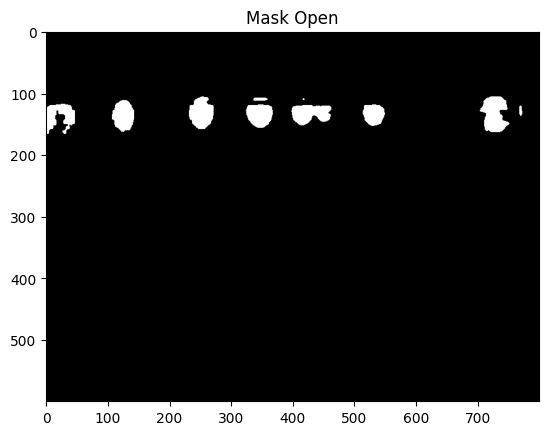

In [41]:
opening_kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, opening_kernel)

plt.imshow(mask_open, cmap='gray')
plt.title("Mask Open")
plt.show()


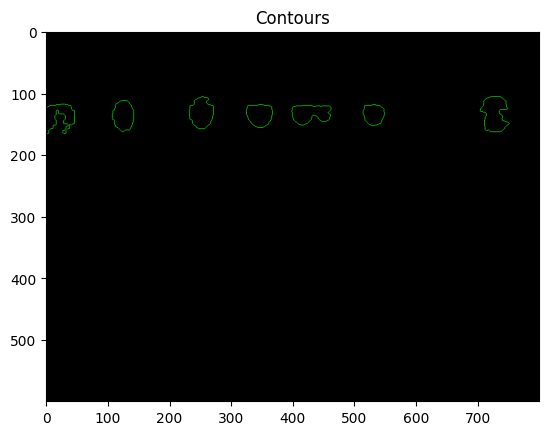

In [42]:
def getContours(base_img):

    # Calcular contornos de la imagen
    contours, _ = cv2.findContours(image=base_img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)

    dim = np.shape(base_img)

    contours_img = cv2.drawContours(np.zeros((dim[0],dim[1],3)), contours, -1, (0,255,0), 1)
    contours_img = np.uint8(contours_img)

    return contours, contours_img

def filterContours(base_img, contours, mult=2.5, mode='DOWN'):
    # Filtrado de contornos por longitud
    contours_lenght = [len(c) for c in contours]

    cl_mean = np.mean(contours_lenght)
    cl_std = np.std(contours_lenght)

    if mode == 'DOWN':
        contours_filtered = [c for c in contours if len(c) < cl_mean + mult*cl_std]
    elif mode == 'UP':
        contours_filtered = [c for c in contours if len(c) > cl_mean + mult*cl_std]

    dim = np.shape(base_img)
    contours_filtered_img = cv2.drawContours(np.zeros((dim[0],dim[1],3)), contours_filtered, -1, (0,255,0), 1)
    contours_filtered_img = np.uint8(contours_filtered_img)

    return contours_filtered, contours_filtered_img

contours, contours_img = getContours(mask_open)
contours_filtered, contours_filtered_img = filterContours(mask_open, contours, mult=-1, mode='UP')

plt.imshow(contours_filtered_img)
plt.title("Contours")
plt.show()

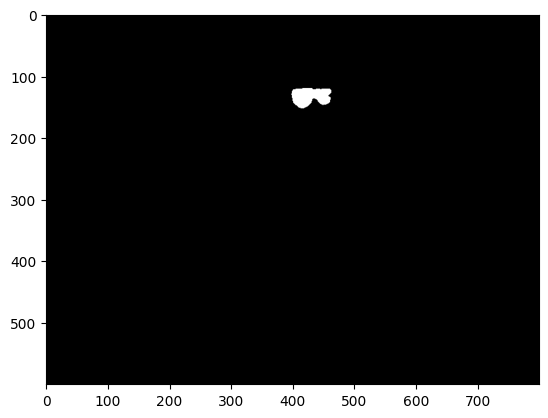

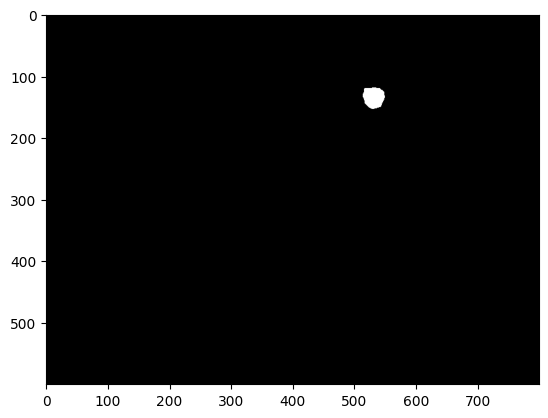

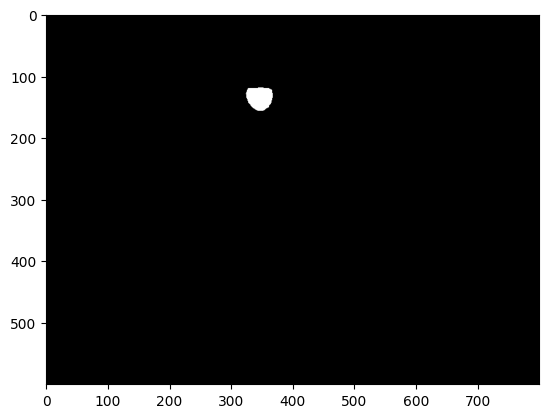

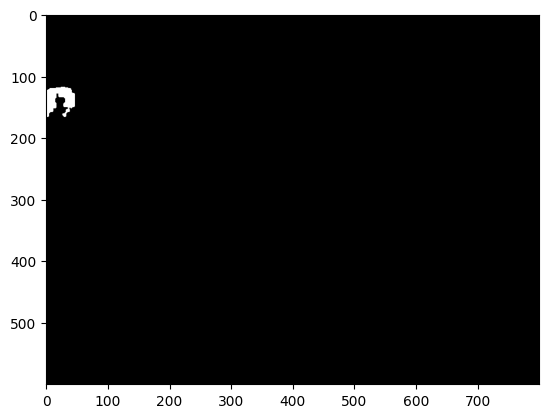

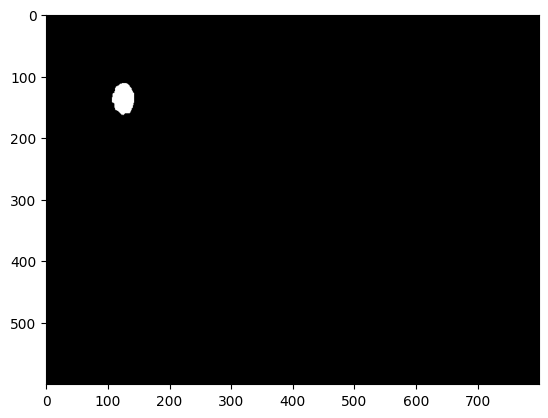

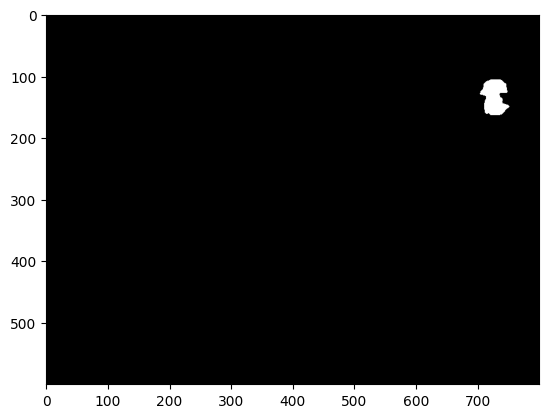

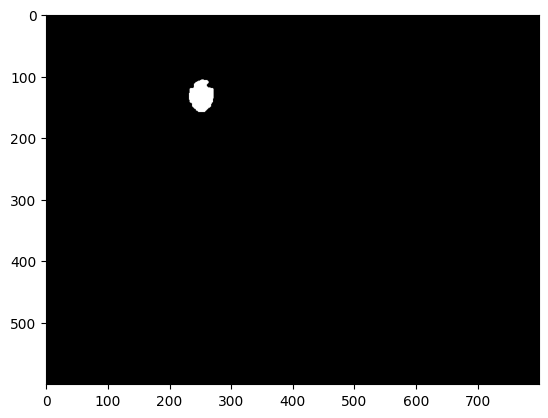

In [43]:
def getIndividualMasks(base_mask,contours):
    # Lista para guardar las máscaras individuales
    individual_masks = []
    
    # Crear una máscara por cada contorno
    for i, contour in enumerate(contours):
        # Máscara en negro (0)
        mask = np.zeros_like(base_mask, dtype=np.uint8)
        
        # Dibujar el contorno RELLENO (cv2.FILLED o thickness=-1)
        cv2.drawContours(
            image=mask,
            contours=[contour],
            contourIdx=-1,  # -1 para dibujar todos los contornos en la lista
            color=255,     # Blanco (255)
            thickness=cv2.FILLED  # Rellenar el contorno
        )
        
        individual_masks.append(mask)
    
    return individual_masks

list_individual_masks = getIndividualMasks(mask_open,contours_filtered)

for individual_maks in list_individual_masks:
    plt.imshow(individual_maks,cmap="gray")
    plt.show()


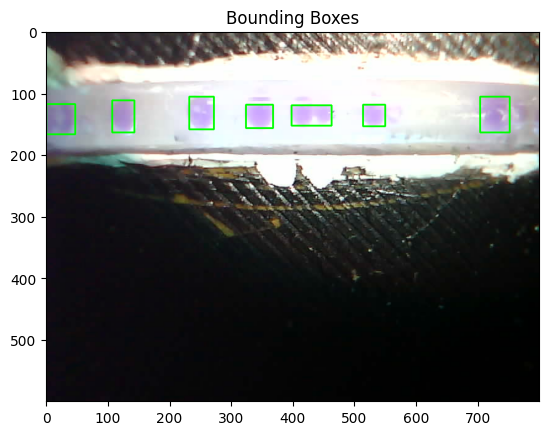

In [44]:
def getBoundingBox(mask):

    # Conversión del la máscara a clase Image
    mask_class = Image.fromarray(mask)

    # Obtención del bounding box
    bbox = mask_class.getbbox()

    # Conversión de bbox a formato utilizable
    x1,y1,x2,y2 = bbox

    bbox_coors = [(x1,y1),(x2,y2)]

    return bbox_coors

list_bboxes = [getBoundingBox(mask) for mask in list_individual_masks]

bgr_img_copy = bgr_img.copy()
for bbox in list_bboxes:
    cv2.rectangle(bgr_img_copy, bbox[0], bbox[1], (0, 255, 0), 2)

plt.imshow(bgr_img_copy)
plt.title("Bounding Boxes")
plt.show()